In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
sns.set_palette('coolwarm')

In [2]:
X = np.genfromtxt('../data/ts_file.dat',skip_header=1).T

<ErrorbarContainer object of 3 artists>

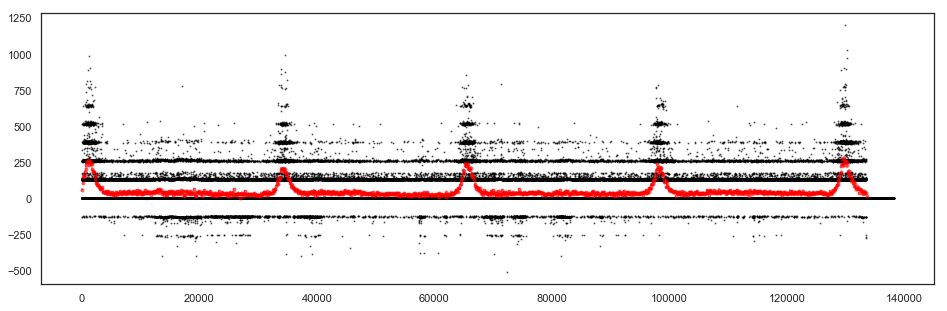

In [3]:
t,y,s=X
t -= t[0]
bins = np.r_[t.min()+50:t.max()+50:100]
ybins = np.zeros_like(bins)
indices = np.digitize(t,bins)
y[~np.isfinite(y)] = 0.0
for i in range(len(bins)):
    c = (indices == i)
    ybins[i] = y[c].sum()
l = ybins > 0
tbin = bins[l]
ybin = ybins[l]
sbin = np.sqrt(ybin)
plt.figure(figsize=(16,5))
plt.plot(t,y*100,'k.',ms=2,alpha=0.5)
plt.errorbar(tbin,ybin,yerr=sbin,fmt='r.',alpha=0.5)

1 [ 214.55215658 1325.10004616  843.4688271    32.58506917]
Orbit: 1
Amplitude (counts): 214.361 +/- 4.617
Time (seconds): 1324.629 +/- 17.763
Half-width (seconds): 846.115 +/- 19.326
DC level (counts): 32.530 +/- 0.990
2 [1.62425043e+02 3.44196280e+04 9.22983960e+02 2.70822811e+01]
Orbit: 2
Amplitude (counts): 162.207 +/- 3.829
Time (seconds): 34419.396 +/- 20.499
Half-width (seconds): 924.728 +/- 20.949
DC level (counts): 26.970 +/- 0.708
3 [1.97507569e+02 6.56559478e+04 9.10618055e+02 2.42218612e+01]
Orbit: 3
Amplitude (counts): 197.758 +/- 4.215
Time (seconds): 65656.930 +/- 16.800
Half-width (seconds): 911.723 +/- 16.685
DC level (counts): 24.177 +/- 0.636
4 [1.66945012e+02 9.82735001e+04 8.88299158e+02 3.04285610e+01]
Orbit: 4
Amplitude (counts): 166.946 +/- 4.025
Time (seconds): 98273.626 +/- 19.112
Half-width (seconds): 888.424 +/- 20.329
DC level (counts): 30.412 +/- 0.711
5 [2.07236487e+02 1.29935149e+05 9.18982817e+02 3.19886521e+01]
Orbit: 5
Amplitude (counts): 207.014 +/- 

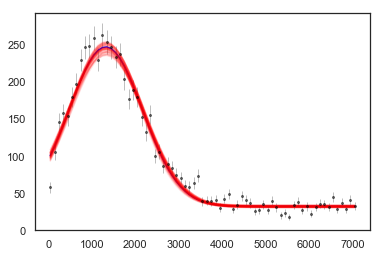

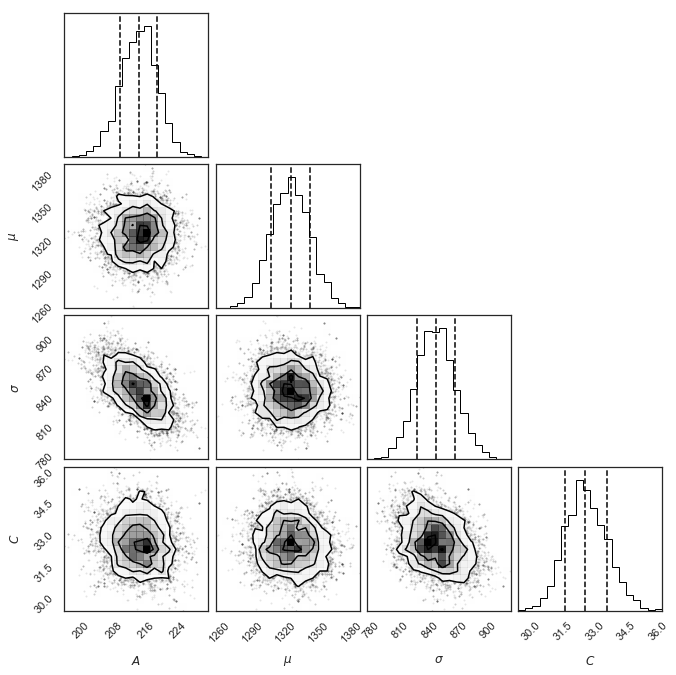

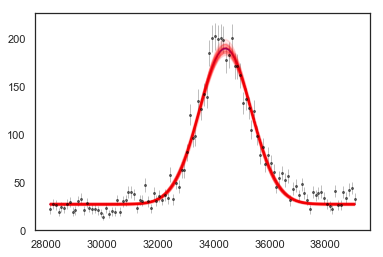

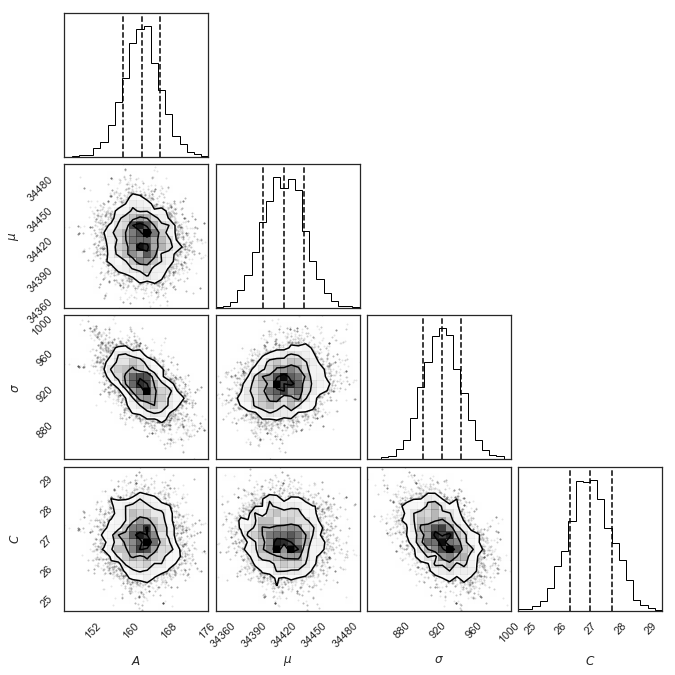

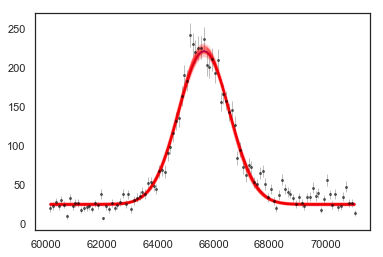

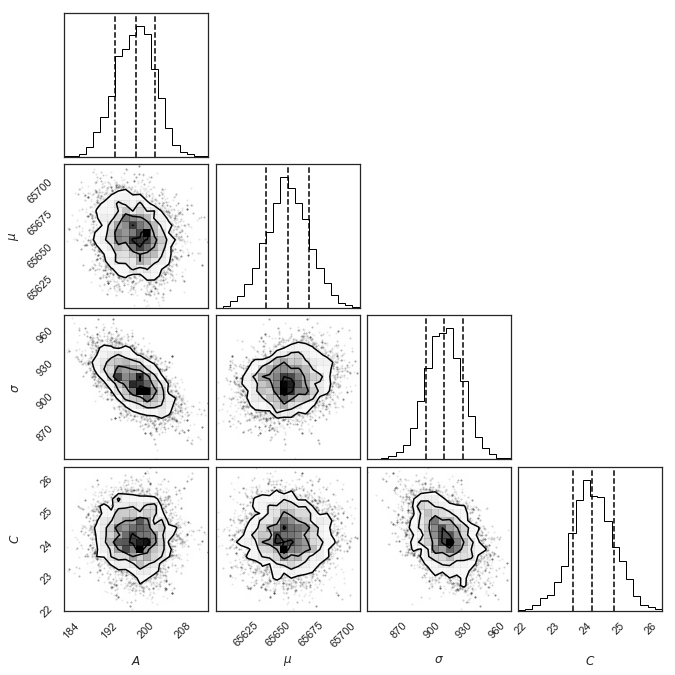

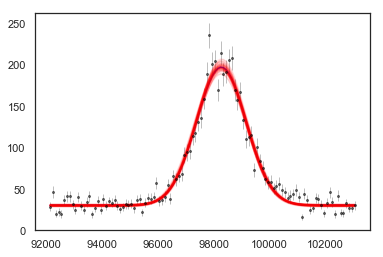

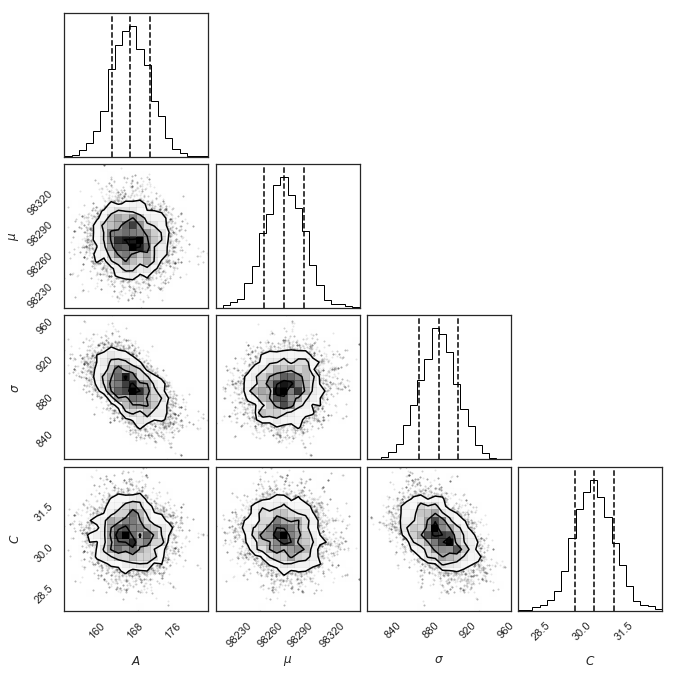

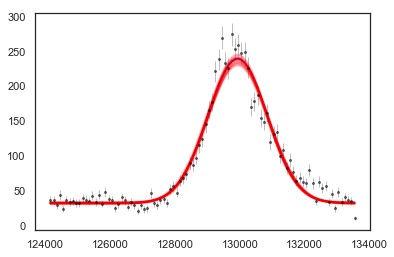

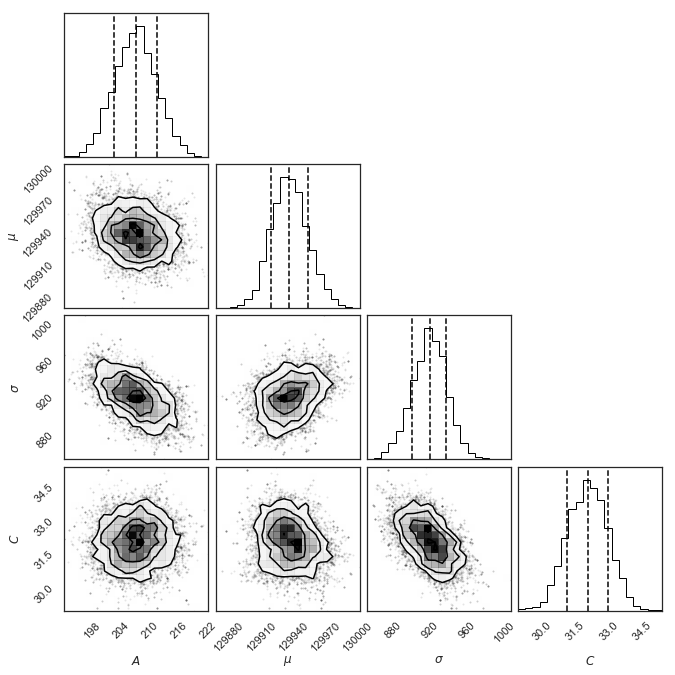

In [42]:
from scipy.optimize import minimize
def gauss(p, t):
    amp, mu, sig, dc = p
    return dc + amp * np.exp(-(t-mu)**2/2/sig**2)
def chi2_gauss(p, t, y, e):
    m = gauss(p, t)
    r = y - m
    return ((r/e)**2).sum()
def lnprob_gauss(p, t, y, e):
    return - 0.5 * chi2_gauss(p, t, y, e)
import emcee, corner
def mcmc_gauss(t, y, e, p_in):
    ndim = len(p_in)
    nwalkers = max(4 * ndim, 24)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_gauss, args=(t,y,e))
    # Initialize the walkers.
    p0 = p_in + 1e-4 * np.random.randn(nwalkers, ndim)
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()
    sampler.run_mcmc(p0, 500)
    return sampler
def fit_gauss(t, y, e, p_in):
    plt.figure()
    plt.errorbar(t,y,fmt='k.',yerr=e,capsize=0,lw=0.5,ms=4,alpha=0.5)
    # first to MLE
    soln = minimize(chi2_gauss,p_in, args = (t,y,e))
    p_mle = soln.x
    m = gauss(p_mle,t)
    plt.plot(t,m,'b-')
    sampler = mcmc_gauss(t, y, e, p_mle)
    x = np.linspace(min(t), max(t), 200)
    for i in range(50):
        # Choose a random walker and step.
        w = np.random.randint(sampler.chain.shape[0])
        n = np.random.randint(sampler.chain.shape[1])
        p = sampler.chain[w, n]
        # Plot a single sample.
        plt.plot(t, gauss(p, t), "r-", alpha=0.1)
    samples = sampler.chain.reshape((-1, len(p_mle)))
    amp_mcmc, mu_mcmc, sig_mcmc, dc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                               zip(*np.percentile(samples, [16, 50, 84],
                                                                  axis=0)))
    labels = [r"$A$", r"$\mu$", r"$\sigma$",r"$C$"]
    corner.corner(sampler.flatchain, quantiles=[0.16, 0.5, 0.84],labels=labels)
    return p_mle, amp_mcmc, mu_mcmc, sig_mcmc, dc_mcmc
def fit_gauss_all(t, y, e, per_in = 32000, sig_in = 780.0, amp_in = 200.0, t0_in = 1600.0):
    w = 14 * sig_in
    t0 = t0_in
    o = 1
    orbit = []
    mu_fit = []
    amp_fit = []
    sig_fit = []
    dc_fit = []
    mu_err = []
    amp_err = []
    sig_err = []
    dc_err = []
    while (t0 - w/2.) < t.max():
        l = abs(t-t0) <= (w/2.)
        p_in = np.array([amp_in,t0,sig_in,np.median(y)])
        if l.sum() > 0:
            p_mle, amp_mcmc, mu_mcmc, sig_mcmc, dc_mcmc = fit_gauss(t[l], y[l], e[l], p_in)
            print(o,p_mle)
            amp_fit.append(amp_mcmc[0])
            amp_err.append(0.5*(amp_mcmc[1]+amp_mcmc[2]))
            mu_fit.append(mu_mcmc[0])
            mu_err.append(0.5*(mu_mcmc[1]+mu_mcmc[2]))
            sig_fit.append(sig_mcmc[0])
            sig_err.append(0.5*(sig_mcmc[1]+sig_mcmc[2]))
            dc_fit.append(dc_mcmc[0])
            dc_err.append(0.5*(dc_mcmc[1]+dc_mcmc[2]))
            orbit.append(o)
            print('Orbit: {:d}'.format(o))
            print('Amplitude (counts): {:.3f} +/- {:.3f}'.format(amp_fit[-1],amp_err[-1]))
            print('Time (seconds): {:.3f} +/- {:.3f}'.format(mu_fit[-1],mu_err[-1]))
            print('Half-width (seconds): {:.3f} +/- {:.3f}'.format(sig_fit[-1],sig_err[-1]))
            print('DC level (counts): {:.3f} +/- {:.3f}'.format(dc_fit[-1],dc_err[-1]))
        t0 += per_in
        o += 1
    return 
res = fit_gauss_all(tbin,ybin,sbin)

### TBD: use GP to model correlated noise

### TBD: test assumption of Gaussian pulses

In [44]:
orbit, amp_fit, mu_fit, sig_fit, dc_fit, amp_err, mu_err, sig_err, dc_err = res
fig,axes = plt.subplots(5,1,figsize=(10,10),sharex =True)
axes[0].errorbar(orbit,amp_fit,yerr=amp_err,fmt='.')
axes[1].errorbar(orbit,mu_fit,yerr=mu_err,fmt='.')
orb = np.array(orbit)
mus = np.array(mu_fit)
mue = np.array(mu_err)
l_odd = (orb%2)==1
print(l_odd)
l_even = ~l_odd
print(l_even)
p_odd = np.polyfit(orb[l_odd],mus[l_odd],1)
v_odd = np.polyval(p_odd,orb[l_odd])
print(p_odd)
p_even = np.polyfit(orb[l_even],mus[l_even],1)
print(p_even)
v_even = np.polyval(p_even,orb[l_even])
p_even = np.polyfit(np.array(orbit)[1::2],np.array(mu_fit)[1::2],1)
axes[2].errorbar(orb[l_odd],mus[l_odd]-v_odd,yerr=mue[l_odd],fmt='.',color='r')
axes[2].errorbar(orb[l_even],mus[l_even]-v_even,yerr=mue[l_even],fmt='.',color='b')
axes[3].errorbar(orbit,sig_fit,yerr=sig_err,fmt='.')
axes[4].errorbar(orbit,dc_fit,yerr=dc_err,fmt='.')
axes[0].set_ylabel('amplitude')
axes[1].set_ylabel('position')
axes[2].set_ylabel('O-C')
axes[3].set_ylabel('half-width')
axes[4].set_ylabel('dc level')
axes[4].set_xlabel('orbit number')


TypeError: cannot unpack non-iterable NoneType object

### TBD: fit ephemeris properly:
- accounting for individual uncertainties on individual times
- using one period for all pulses but different offsets for odd and even
- computing uncertainties on ephemeris parameters